In [140]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [141]:
import persepctiveTransform

In [187]:
cap = cv2.VideoCapture("./2021-07-27 12-26-46.mp4")
cap.isOpened()

True

In [188]:
cap.get(cv2.CAP_PROP_FPS)

24.0

In [189]:
cap.set(1, 3)
ret, frame = cap.read()
image = Image.fromarray(frame)
image.show()

## Get reference points

In [242]:
# frame = frame[225:765,990:1920,:]
ori_coord = persepctiveTransform.GetReferences(frame)

[[81, 540]]
[[81, 540], [787, 543]]
[[81, 540], [787, 543], [688, 464]]
[[81, 540], [787, 543], [688, 464], [182, 465]]


In [243]:
x_min = min(ori_coord[:,0])
x_max = max(ori_coord[:,0])
y_min = min(ori_coord[:,1])
y_max = max(ori_coord[:,1])

constant = 2000

dx = x_max - x_min
dx_real = 2
x_ratio = dx_real/dx

dy = y_max - y_min
dy_real = 1
y_ratio = dy_real/dy


# transformed = np.float32([[x_min + constant, y_max + constant], 
#                           [x_max + constant, y_max + constant], 
#                           [x_max + constant, y_min + constant], 
#                           [x_min + constant, y_min + constant]])

transformed = np.float32([[0, 0], 
                          [2000,0], 
                          [2000,1000], 
                          [0,1000]])



## Calibrate Camera

In [18]:
# cam_cali = [[263, 297,0], [283, 100,0], [275, 96,0], [252, 298,0]]
# cam_cali = np.float32(cam_cali)
# print(cam_cali,transformed)

[[263. 297.   0.]
 [283. 100.   0.]
 [275.  96.   0.]
 [252. 298.   0.]] [[[263. 297.]
  [263. 100.]
  [252. 100.]
  [252. 297.]]]


In [171]:
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([cam_cali], [transformed],(6000,4000),cameraMatrix = None,distCoeffs = None)
# print(ret, mtx, dist, rvecs, tvecs)
# img = frame
# # print(frame)
# h,  w = img.shape[:2]
# # print(h,w)
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# # print(newcameramtx, roi)
# # undistort
# dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# # crop the image
# # x, y, w, h = roi
# # dst = dst[y:y+h, x:x+w]
# # print(dst)
# image = Image.fromarray(dst)
# image.show()
# # undistort
# mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
# dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# image = Image.fromarray(dst)
# image.show()

3.3640766946796545 [[1.17532253e+03 0.00000000e+00 2.94881106e+03]
 [0.00000000e+00 2.55001892e+03 1.98779254e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.05027716 -0.44733212 -0.0144173  -0.10848275 -0.03191775]] [array([[0.29882064],
       [0.17910396],
       [1.35203329]])] [array([[   2.24478472],
       [-240.37091034],
       [ 209.7736142 ]])]


In [244]:
M = cv2.getPerspectiveTransform(ori_coord,transformed)
M

array([[-2.83100385e+00, -3.81241851e+00,  2.28801731e+03],
       [-3.86288604e-02,  9.09065849e+00, -4.90582665e+03],
       [-6.37096626e-05, -3.60022740e-03,  1.00000000e+00]])

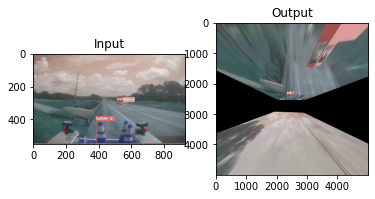

In [193]:
dst = cv2.warpPerspective(frame,M,(5000,5000))
plt.subplot(121),plt.imshow(frame),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [194]:
image = Image.fromarray(dst)
image.show()

In [256]:
trajectory = pd.read_csv('2021-07-27 12-26-46.mp4.csv', header = None)
trajectory.columns = ['frame','ID','type','minx','miny','maxx','maxy']
trajectory

,frame,ID,type,minx,miny,maxx,maxy
0,3,1,car,506,291,538,307
1,3,2,bottle,384,410,448,545
2,3,3,car,539,290,564,306
3,4,1,car,510,291,542,307
4,4,2,bottle,384,410,447,545
...,...,...,...,...,...,...,...
48255,33111,2479,car,820,311,932,411
48256,33112,2474,car,479,268,513,298
48257,33112,2479,car,820,311,932,411
48258,33113,2474,car,479,268,514,298


## Show transformed point on figure

In [257]:
single_veh = np.float32([506, 307])

In [122]:
homg_point = [single_veh[0], single_veh[1], 1] # homogeneous coords
transf_homg_point = M.dot(homg_point) # transform
transf_homg_point /= transf_homg_point[2] # scale
transf_point = transf_homg_point[:2] # remove Cartesian coords
transf_point

array([2963.1128573 , 1365.26003976])

In [123]:
img = cv2.circle(dst,(2956,   1425),10,(255,0,0),-1)
scale_width = 640 / img.shape[1]
scale_height = 480 / img.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img.shape[1] * scale)
window_height = int(img.shape[0] * scale)
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', window_width, window_height)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Calculate speed

In [246]:
list_ID = trajectory['ID'].unique()
list_ID

array([   1,    2,    3, ..., 2478, 2479, 2480], dtype=int64)

In [247]:
single_id = 1

In [258]:
def cal_distance(o,d):
    distance = np.sqrt((o[0]-d[0])**2 + (o[1]-d[1])**2)
    return(distance)

In [260]:
i = 0
for single_id in list_ID[1:100]:
    single_veh = trajectory[trajectory['ID'] == single_id].sort_values(by='frame')
    single_veh = single_veh.reset_index(drop=True)
#     print(single_veh)
    for idx, row in single_veh.iterrows():
    #     print(idx,row)
        ori_coord = np.float32([row['maxx'],row['maxy']])
        single_veh.loc[idx,['transformed_x','transformed_y']] = persepctiveTransform.transform_point(ori_coord,M)
        
        if idx > 0:
#             print(idx-1)
            o = [single_veh.loc[idx-1,'transformed_x'], single_veh.loc[idx-1,'transformed_y']] 
            d = [single_veh.loc[idx,'transformed_x'], single_veh.loc[idx,'transformed_y']]
            single_veh.loc[idx,'distance'] = cal_distance(o, d)
            single_veh.loc[idx,'speed'] = single_veh.loc[idx,'distance']/(single_veh.loc[idx,'frame']-single_veh.loc[idx-1,'frame'])       
    if i == 0:
        df_speed = single_veh
    else: 
        df_speed = pd.concat([df_speed,single_veh], axis=0)
    i += 1
    print(df_speed)
print(df_speed)
    
    
    

     frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0        3   2  bottle   384   410   448   545         1068.0          -31.0   
1        4   2  bottle   384   410   447   545         1065.0          -31.0   
2        5   2  bottle   384   410   448   545         1068.0          -31.0   
3        6   2  bottle   384   410   448   545         1068.0          -31.0   
4        7   2  bottle   384   410   448   545         1068.0          -31.0   
..     ...  ..     ...   ...   ...   ...   ...            ...            ...   
244    549   2  bottle   379   410   450   544         1073.0          -22.0   
245    554   2  bottle   379   410   450   543         1073.0          -13.0   
246    555   2  bottle   379   410   451   542         1076.0           -3.0   
247    556   2  bottle   380   410   451   542         1076.0           -3.0   
248    557   2  bottle   380   410   451   542         1076.0           -3.0   

      distance      speed  
0          

    frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3   2  bottle   384   410   448   545         1068.0          -31.0   
1       4   2  bottle   384   410   447   545         1065.0          -31.0   
2       5   2  bottle   384   410   448   545         1068.0          -31.0   
3       6   2  bottle   384   410   448   545         1068.0          -31.0   
4       7   2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ..     ...   ...   ...   ...   ...            ...            ...   
31    197  22   truck   567   265   712   357         3292.0         5105.0   
32    198  22   truck   579   265   744   364         3369.0         4542.0   
33    199  22   truck   579   265   758   367         3401.0         4326.0   
34    200  22   truck   578   265   766   368         3434.0         4255.0   
35    201  22   truck   581   265   775   371         3429.0         4059.0   

      distance       speed  
0          NaN        

    frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3   2  bottle   384   410   448   545         1068.0          -31.0   
1       4   2  bottle   384   410   447   545         1065.0          -31.0   
2       5   2  bottle   384   410   448   545         1068.0          -31.0   
3       6   2  bottle   384   410   448   545         1068.0          -31.0   
4       7   2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ..     ...   ...   ...   ...   ...            ...            ...   
11    467  36     car   540   295   593   321         3176.0        10393.0   
12    468  36     car   548   296   607   325         3206.0         9460.0   
13    469  36     car   552   296   612   326         3232.0         9244.0   
14    470  36     car   553   296   614   327         3220.0         9043.0   
15    471  36     car   556   296   619   328         3244.0         8842.0   

      distance       speed  
0          NaN        

[767 rows x 11 columns]
    frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3   2  bottle   384   410   448   545         1068.0          -31.0   
1       4   2  bottle   384   410   447   545         1065.0          -31.0   
2       5   2  bottle   384   410   448   545         1068.0          -31.0   
3       6   2  bottle   384   410   448   545         1068.0          -31.0   
4       7   2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ..     ...   ...   ...   ...   ...            ...            ...   
73    650  53     car   610   267   761   363         3518.0         4601.0   
74    676  53     car   821   309   938   388         4043.0         3098.0   
75    677  53     car   825   310   937   388         4038.0         3098.0   
76    678  53     car   828   310   936   388         4032.0         3099.0   
77    679  53     car   834   311   941   388         4060.0         3097.0   

       distance       speed

     frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0        3   2  bottle   384   410   448   545         1068.0          -31.0   
1        4   2  bottle   384   410   447   545         1065.0          -31.0   
2        5   2  bottle   384   410   448   545         1068.0          -31.0   
3        6   2  bottle   384   410   448   545         1068.0          -31.0   
4        7   2  bottle   384   410   448   545         1068.0          -31.0   
..     ...  ..     ...   ...   ...   ...   ...            ...            ...   
470   1394  66  bottle   379   410   450   542         1073.0           -4.0   
471   1395  66  bottle   379   410   450   542         1073.0           -4.0   
472   1396  66  bottle   379   410   450   542         1073.0           -4.0   
473   1397  66  bottle   379   410   450   542         1073.0           -4.0   
474   1398  66  bottle   378   409   450   542         1073.0           -4.0   

     distance  speed  
0         NaN   

    frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3   2  bottle   384   410   448   545         1068.0          -31.0   
1       4   2  bottle   384   410   447   545         1065.0          -31.0   
2       5   2  bottle   384   410   448   545         1068.0          -31.0   
3       6   2  bottle   384   410   448   545         1068.0          -31.0   
4       7   2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ..     ...   ...   ...   ...   ...            ...            ...   
2     803  80     car   527   290   563   305         3498.0        16088.0   
3     806  80     car   537   290   574   306         3642.0        15525.0   
4     807  80     car   537   291   575   307         3595.0        15061.0   
5     808  80     car   538   291   576   307         3613.0        15054.0   
6     809  80     car   540   291   578   307         3650.0        15041.0   

      distance       speed  
0          NaN        

    frame  ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3   2  bottle   384   410   448   545         1068.0          -31.0   
1       4   2  bottle   384   410   447   545         1065.0          -31.0   
2       5   2  bottle   384   410   448   545         1068.0          -31.0   
3       6   2  bottle   384   410   448   545         1068.0          -31.0   
4       7   2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ..     ...   ...   ...   ...   ...            ...            ...   
42    975  87   truck   712   264   962   439         3286.0         1483.0   
43    976  87   truck   747   265   990   446         3312.0         1330.0   
44    977  87   truck   765   265   997   448         3315.0         1288.0   
45    978  87   truck   775   265   995   449         3295.0         1268.0   
46    979  87   truck   785   265  1012   455         3290.0         1151.0   

      distance       speed  
0          NaN        

    frame   ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3    2  bottle   384   410   448   545         1068.0          -31.0   
1       4    2  bottle   384   410   447   545         1065.0          -31.0   
2       5    2  bottle   384   410   448   545         1068.0          -31.0   
3       6    2  bottle   384   410   448   545         1068.0          -31.0   
4       7    2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ...     ...   ...   ...   ...   ...            ...            ...   
8    1087   97     car   463   283   483   293         2293.0        26400.0   
0    1002   99     car   888   322   929   385         4064.0         3238.0   
1    1003   99     car   889   323   928   386         4034.0         3192.0   
0    1017  100     car   531   292   559   305         3420.0        16118.0   
1    1018  100     car   531   292   559   305         3420.0        16118.0   

       distance        speed  
0       

    frame   ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3    2  bottle   384   410   448   545         1068.0          -31.0   
1       4    2  bottle   384   410   447   545         1065.0          -31.0   
2       5    2  bottle   384   410   448   545         1068.0          -31.0   
3       6    2  bottle   384   410   448   545         1068.0          -31.0   
4       7    2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ...     ...   ...   ...   ...   ...            ...            ...   
3    1155  109   truck   739   312   987   433         3469.0         1620.0   
0    1315  111     car   445   278   470   289         2050.0        32620.0   
1    1316  111     car   445   278   470   289         2050.0        32620.0   
2    1320  111     car   446   278   471   289         2088.0        32591.0   
3    1321  111     car   446   278   471   289         2088.0        32591.0   

      distance       speed  
0         

    frame   ID    type  minx  miny  maxx  maxy  transformed_x  transformed_y  \
0       3    2  bottle   384   410   448   545         1068.0          -31.0   
1       4    2  bottle   384   410   447   545         1065.0          -31.0   
2       5    2  bottle   384   410   448   545         1068.0          -31.0   
3       6    2  bottle   384   410   448   545         1068.0          -31.0   
4       7    2  bottle   384   410   448   545         1068.0          -31.0   
..    ...  ...     ...   ...   ...   ...   ...            ...            ...   
12   1558  126     car   480   286   504   297         2674.0        21951.0   
13   1584  126     car   468   284   491   294         2483.0        25093.0   
14   1585  126     car   468   284   490   294         2453.0        25111.0   
15   1586  126     car   468   284   490   294         2453.0        25111.0   
16   1587  126     car   468   284   490   294         2453.0        25111.0   

       distance       speed  
0        

In [261]:
df_speed

,frame,ID,type,minx,miny,maxx,maxy,transformed_x,transformed_y,distance,speed
0,3,2,bottle,384,410,448,545,1068.0,-31.0,NaN,NaN
1,4,2,bottle,384,410,447,545,1065.0,-31.0,3.000000,3.000000
2,5,2,bottle,384,410,448,545,1068.0,-31.0,3.000000,3.000000
3,6,2,bottle,384,410,448,545,1068.0,-31.0,0.000000,0.000000
4,7,2,bottle,384,410,448,545,1068.0,-31.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
40,1737,139,car,532,289,562,304,3546.0,16610.0,0.000000,0.000000
41,1738,139,car,539,292,569,306,3548.0,15560.0,1050.001905,1050.001905
42,1739,139,car,541,292,572,306,3605.0,15539.0,60.745370,60.745370
43,1740,139,car,542,293,573,307,3558.0,15074.0,467.369233,467.369233


In [262]:
df_speed['real_speed'] = df_speed['speed']*24*3.6/1000

In [131]:
78.517514*24*3/700*3600/1000

29.07391375542857

In [263]:
df_speed['real_speed']

0           NaN
1      0.259200
2      0.259200
3      0.000000
4      0.000000
        ...    
40     0.000000
41    90.720165
42     5.248400
43    40.380702
44     3.388378
Name: real_speed, Length: 2164, dtype: float64

In [264]:
df_speed.describe()

,frame,ID,minx,miny,maxx,maxy,transformed_x,transformed_y,distance,speed,real_speed
count,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2065.000000,2065.000000,2065.000000
mean,843.714880,64.206562,492.362754,330.329945,563.571165,403.036506,2300.092884,7554.175601,391.066306,180.501600,15.595338
std,491.582185,41.615741,141.184089,57.520048,170.831276,104.205157,1707.419355,7526.928132,1336.686802,297.897695,25.738361
min,3.000000,2.000000,13.000000,217.000000,40.000000,289.000000,-7128.000000,-31.000000,0.000000,0.000000,0.000000
25%,488.750000,34.000000,383.000000,287.000000,449.000000,313.000000,1070.000000,-13.000000,0.000000,0.000000,0.000000
50%,793.500000,66.000000,502.000000,300.000000,534.000000,347.000000,2907.000000,6058.000000,20.248457,19.924859,1.721508
75%,1244.250000,95.000000,571.000000,409.000000,637.250000,543.000000,3434.000000,12955.500000,314.006369,267.067407,23.074624
max,1747.000000,139.000000,890.000000,411.000000,1035.000000,545.000000,4604.000000,32620.000000,19577.298716,2222.629299,192.035171


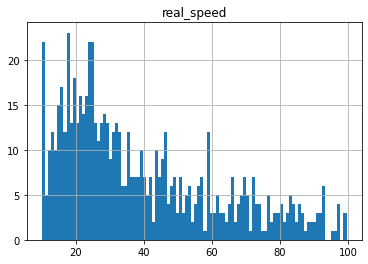

In [265]:
df_speed = df_speed.replace(np.nan, 0)
filterrule = df_speed["real_speed"]>10
filtered = df_speed[filterrule]
filterrule = filtered["real_speed"]<100
filtered = filtered[filterrule]
ax = filtered.hist(column="real_speed",bins=100)

In [63]:
filtered = df_speed[filterrule]
filtered

,frame,ID,type,minx,miny,maxx,maxy,transformed_x,transformed_y,distance,speed,real_speed
0,3,1,car,506,291,538,307,2861.0,1441.0,0.000000,0.000000,0.000000
1,4,1,car,510,291,542,307,2886.0,1443.0,25.079872,25.079872,3.908552
2,5,1,car,512,292,544,308,2889.0,1474.0,31.144823,31.144823,4.853739
3,6,1,car,512,291,545,308,2889.0,1474.0,0.000000,0.000000,0.000000
4,7,1,car,512,291,546,308,2889.0,1474.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7,33112,2479,car,820,311,932,411,3133.0,2373.0,0.000000,0.000000,0.000000
8,33113,2479,car,821,311,932,410,3139.0,2371.0,6.324555,6.324555,0.985645
0,33105,2480,truck,808,316,930,422,3068.0,2398.0,0.000000,0.000000,0.000000
1,33106,2480,truck,807,316,930,423,3063.0,2400.0,5.385165,5.385165,0.839246


# Test on scaling method

In [84]:
def real_dis(y):
    W = 2.5
    P = 500
    D =1.5
    F = P*D/W
    dx = 700-500
    dy = 100
    ratio = dx/dy
    p = 500-ratio * (458-y)*2
    d = F*W/p
    return(d)

In [85]:
trajectory = pd.read_csv('2021-07-27 12-26-46.mp4.csv', header = None)
trajectory.columns = ['frame','ID','type','minx','miny','maxx','maxy']
trajectory

,frame,ID,type,minx,miny,maxx,maxy
0,3,1,car,506,291,538,307
1,3,2,bottle,384,410,448,545
2,3,3,car,539,290,564,306
3,4,1,car,510,291,542,307
4,4,2,bottle,384,410,447,545
...,...,...,...,...,...,...,...
48255,33111,2479,car,820,311,932,411
48256,33112,2474,car,479,268,513,298
48257,33112,2479,car,820,311,932,411
48258,33113,2474,car,479,268,514,298


In [97]:
list_ID = trajectory['ID'].unique()
list_ID

array([   1,    2,    3, ..., 2478, 2479, 2480], dtype=int64)

In [101]:
i = 0
for single_id in list_ID[1:100]:
    single_veh = trajectory[trajectory['ID'] == single_id].sort_values(by='frame')
    single_veh = single_veh.reset_index(drop=True)
#     print(single_veh)
    for idx, row in single_veh.iterrows():
    #     print(idx,row)
        y =  row['maxy']
        d = real_dis(y)
        single_veh.loc[idx,'distance'] = d
        
        if idx > 0:
            dis = single_veh.loc[idx-1,'distance'] - single_veh.loc[idx,'distance']
            single_veh.loc[idx,'speed'] = dis/(single_veh.loc[idx,'frame']-single_veh.loc[idx-1,'frame'])       
    if i == 0:
        df_speed = single_veh
    else: 
        df_speed = pd.concat([df_speed,single_veh], axis=0)
    i += 1
    print(df_speed)
print(df_speed)
    
    
    

     frame  ID    type  minx  miny  maxx  maxy  distance     speed
0        3   2  bottle   384   410   448   545  0.884434       NaN
1        4   2  bottle   384   410   447   545  0.884434  0.000000
2        5   2  bottle   384   410   448   545  0.884434  0.000000
3        6   2  bottle   384   410   448   545  0.884434  0.000000
4        7   2  bottle   384   410   448   545  0.884434  0.000000
..     ...  ..     ...   ...   ...   ...   ...       ...       ...
244    549   2  bottle   379   410   450   544  0.888626  0.000000
245    554   2  bottle   379   410   450   543  0.892857 -0.000846
246    555   2  bottle   379   410   451   542  0.897129 -0.004272
247    556   2  bottle   380   410   451   542  0.897129  0.000000
248    557   2  bottle   380   410   451   542  0.897129  0.000000

[249 rows x 9 columns]
    frame  ID    type  minx  miny  maxx  maxy  distance     speed
0       3   2  bottle   384   410   448   545  0.884434       NaN
1       4   2  bottle   384   410   447 

    frame  ID    type  minx  miny  maxx  maxy   distance  speed
0       3   2  bottle   384   410   448   545   0.884434    NaN
1       4   2  bottle   384   410   447   545   0.884434    0.0
2       5   2  bottle   384   410   448   545   0.884434    0.0
3       6   2  bottle   384   410   448   545   0.884434    0.0
4       7   2  bottle   384   410   448   545   0.884434    0.0
..    ...  ..     ...   ...   ...   ...   ...        ...    ...
0      64  13   truck   529   283   575   315 -10.416667    NaN
1      65  13   truck   529   283   575   315 -10.416667    0.0
2      66  13   truck   529   283   575   315 -10.416667    0.0
0      82  15     car   592   299   637   319 -13.392857    NaN
1      83  15     car   592   299   637   319 -13.392857    0.0

[393 rows x 9 columns]


ZeroDivisionError: float division by zero

In [223]:
df_speed['real_speed'] = df_speed['speed']*24*3.6/1000

In [224]:
df_speed['real_speed']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
        ...    
40     0.000000
41    75.458121
42     3.403765
43    33.213805
44     3.290014
Name: real_speed, Length: 2164, dtype: float64

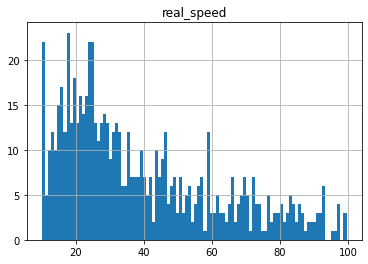

In [266]:
df_speed = df_speed.replace(np.nan, 0)
filterrule = df_speed["real_speed"]>10
filtered = df_speed[filterrule]
filterrule = filtered["real_speed"]<100
filtered = filtered[filterrule]
ax = filtered.hist(column="real_speed",bins=100)

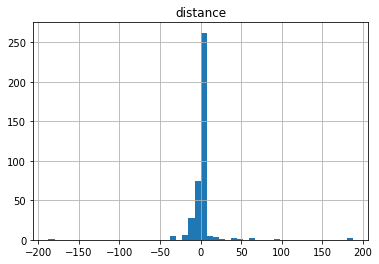

In [91]:
filterrule = filtered["type"] == 'car'
filtered = filtered[filterrule]
ax = df_speed.hist(column="distance",bins=50)

In [268]:
df_speed[df_speed["ID"] == 27]


,frame,ID,type,minx,miny,maxx,maxy,transformed_x,transformed_y,distance,speed,real_speed
0,298,27,car,472,276,509,299,2689.0,20270.0,0.000000,0.000000,0.000000
1,299,27,car,474,276,511,299,2738.0,20247.0,54.129474,54.129474,4.676787
2,300,27,car,475,276,512,299,2762.0,20236.0,26.400758,26.400758,2.281025
3,301,27,car,475,276,512,299,2762.0,20236.0,0.000000,0.000000,0.000000
4,302,27,car,476,276,512,299,2762.0,20236.0,0.000000,0.000000,0.000000
5,303,27,car,478,276,515,299,2835.0,20201.0,80.956779,80.956779,6.994666
6,304,27,car,479,276,516,299,2859.0,20190.0,26.400758,26.400758,2.281025
7,305,27,car,479,276,517,299,2883.0,20178.0,26.832816,26.832816,2.318355
8,306,27,car,479,276,518,300,2849.0,19444.0,734.787044,734.787044,63.485601
9,308,27,car,481,277,522,302,2830.0,18092.0,1352.133499,676.066750,58.412167


In [103]:
0.28*24*3.6

24.192000000000004